In [1]:
start_times = {'indy_20160426_01': 0,
               'indy_20160622_01':1700,
               'indy_20160624_03': 500,
               'indy_20160627_01': 0,
               'indy_20160630_01': 0,
               'indy_20160915_01': 0,
               'indy_20160921_01': 0,
               'indy_20160930_02': 0,
               'indy_20160930_05': 300,
               'indy_20161005_06': 0,
               'indy_20161006_02': 350,
               'indy_20161007_02': 950,
               'indy_20161011_03': 0,
               'indy_20161013_03': 0,
               'indy_20161014_04': 0,
               'indy_20161017_02': 0,
               'indy_20161024_03': 0,
               'indy_20161025_04': 0,
               'indy_20161026_03': 0,
               'indy_20161027_03': 500,
               'indy_20161206_02': 5500,
               'indy_20161207_02': 0,
               'indy_20161212_02': 0,
               'indy_20161220_02': 0,
               'indy_20170123_02': 0,
               'indy_20170124_01': 0,
               'indy_20170127_03': 0,
               'indy_20170131_02': 0,
               }

In [2]:
def calc_loadings(U, d=1):
    # Sum over components
    U = np.sum(np.power(np.abs(U), 2), axis=-1)
    # Reshape and then sum over neurons
    U = np.reshape(U, (d, -1))
    loadings = np.sum(U, axis=0)
    loadings /= np.max(loadings)
    return loadings

In [3]:
import numpy as np 
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import sys
import pdb
from scipy.stats import spearmanr

In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize, StandardScaler

In [5]:
sys.path.append('..')

In [17]:
from loaders import load_sabes 
from utils import apply_df_filters
from decoders import lr_decoder
from segmentation import reach_segment_sabes
#from dca.dca import DynamicalComponentsAnalysis
from dca_research.kca import KalmanComponentsAnalysis as KCA
from os import listdir
from os.path import isfile, join
from tqdm import tqdm
import glob
import pickledef acausal_mmse

In [7]:
import warnings
warnings.filterwarnings("ignore")

In [13]:
sabes_decoding_files = glob.glob('/media/akumar/Secondary/data/cosyne_results/sabes_decoding/sabes_decoding_*.dat')
sabes_kca_files = glob.glob('/media/akumar/Secondary/data/cosyne_results/sabes_kca/sabes_kca_*.dat')
onlyfiles = [f for f in listdir("/media/akumar/Secondary/data/sabes") 
             if isfile(join("/media/akumar/Secondary/data/sabes", f))]

In [16]:
results_list = []
for file in sabes_kca_files:
    with open(file, 'rb') as f:
        result_ = pickle.load(f)
    results_list.extend(result_)
sabes_kca_df = pd.DataFrame(results_list)

In [9]:
def fit_DCAnPCAonBin(X):
    """Now just used to calculate PCA and DCA loading"""
    KCAmodel = KCA(d=2, T=3, causal_weights=(0, 1), project_mmse=True)
    PCAmodel = PCA(n_components=2)
    KCAmodel.fit(X)
    extended = X[0]
    for transit in X[1:]:
        extended = np.vstack((extended,transit))
    PCAmodel.fit(extended)
    PCA_loading = calc_loadings(PCAmodel.components_.T)
    KCA_loading = calc_loadings(KCAmodel.coef_)
    return PCA_loading, KCA_loading

In [10]:
def sprVSRsqNsqaured_sum_coef(rsquared, coefs,loading):
    """Given each neuron's loading.
        Get the spearmanr of loading V.S rsqaured of this neruon in the binned model,
        as well as spearmanr of loading V.S squared sum of sin/cos coefficients of this neruon in the model.
        Return correlations"""
    spearmanr_loading_rsquared = spearmanr(loading, rsquared)
    sqaured_sum_coef = np.add(np.square(coefs[:,0]),np.square(coefs[:,1]))
    spearmanr_loading_sqauredsum_coef = spearmanr(loading,sqaured_sum_coef)
    return spearmanr_loading_rsquared.correlation,spearmanr_loading_sqauredsum_coef.correlation

$D(t - \tau) - b_0 = \lVert V(t) \lVert (b_n + b_y sin[\theta (t)] + b_x cos[\theta(t)])$
### we can fit the following linear model
$D(t - \tau) = b_0 + b_n \lVert V(t) \lVert + b_y \lVert V(t) \lVert sin[\theta (t)] + b_x \lVert V(t) \lVert cos[\theta(t)]$

In [18]:
sabes_kca_df.keys()

Index(['dim', 'fold_idx', 'train_idxs', 'test_idxs', 'KCA', 'fit_all',
       'bin_width', 'filter_fn', 'filter_kwargs', 'boxcox', 'spike_threshold',
       'dim_vals', 'n_folds', 'T', 'ols_order', 'data_file', 'PCA', 'SFA'],
      dtype='object')

In [26]:
tau = [0, 2, 4, 6, 8]
data_path = '/media/akumar/Secondary/data/sabes'
decoder_params = {'trainlag': 4, 'testlag': 4, 'decoding_window': 3}
bins = np.arange(-np.pi,np.pi,.25 * np.pi)
times_binning_better = 0
data_files = np.unique(sabes_kca_df['data_file'].values)
results_list = []

for i, file in tqdm(enumerate(data_files)):
    KCA_df = apply_df_filters(sabes_kca_df, data_file=file, fold_idx=1, dim=1)    
    dat = load_sabes('%s/%s' % (data_path, file), bin_width=KCA_df.iloc[0]["bin_width"],
                     filter_fn=KCA_df.iloc[0]['filter_fn'], filter_kwargs=KCA_df.iloc[0]['filter_kwargs'],
                     boxcox=KCA_df.iloc[0]['boxcox'], spike_threshold=KCA_df.iloc[0]['spike_threshold'])
    
    dat_segmented = reach_segment_sabes(dat, start_times[file.split(".")[0]])
    spike_rates = dat_segmented['spike_rates']
    spike_rates = spike_rates.reshape(spike_rates.shape[1], -1)
    vels = dat_segmented['vel']
    #‖𝑉(𝑡)‖
    peak_vels_in_windows = np.array([np.amax(np.absolute(vels[start : end + 1])) \
                                    for start, end in dat_segmented['transition_times']])[:,np.newaxis]
    orientation_in_windows = dat_segmented['transition_orientation']

    #‖𝑉(𝑡)‖𝑠𝑖𝑛[𝜃(𝑡)]
    peak_vels_in_windows = normalize(peak_vels_in_windows, axis = 0)
    vel_sin = normalize(np.sin(orientation_in_windows)[:,np.newaxis] * peak_vels_in_windows, axis = 0)
#     vel_sin = np.sin(orientation_in_windows)[:,np.newaxis] * peak_vels_in_windows
    #‖𝑉(𝑡)‖𝑐𝑜𝑠[𝜃(𝑡)]
    vel_cos = np.cos(orientation_in_windows)[:,np.newaxis] * peak_vels_in_windows
#    vel_cos = normalize(np.cos(orientation_in_windows)[:,np.newaxis] * peak_vels_in_windows, axis = 0)

    #Binning
    binned_indices = np.digitize(orientation_in_windows, bins)
    binned_indices = [np.where(binned_indices == idx) for idx in range(1,9)]

    #To record the r^2 and coeffs indexed by (bin#, neuron#)
    r_squared_bin_neuron = np.zeros((len(binned_indices), len(tau), spike_rates.shape[1]))
    coefficients_bin_neuron = np.zeros((len(binned_indices), len(tau), spike_rates.shape[1], 2))

    for j in range(8):
        binned_idx = binned_indices[j]
        transitions_inbin = np.array(dat_segmented['transition_times'])[binned_idx]
        # Get the input as ‖𝑉(𝑡)‖, ‖𝑉(𝑡)‖𝑠𝑖𝑛[𝜃(𝑡)], ‖𝑉(𝑡)‖𝑐𝑜𝑠[𝜃(𝑡)]
        X = np.concatenate((peak_vels_in_windows[binned_idx], \
                            vel_sin[binned_idx], vel_cos[binned_idx]), axis = 1)
        for k, t_ in enumerate(tau):
            for neuron_idx in range(spike_rates.shape[1]):
                spike_rates_neuron = spike_rates[:,neuron_idx]
                average_rates_in_windows = np.array([np.average(spike_rates_neuron[max(start_time - t_, 0): \
                                                                                   min(end_time + 1 - t_, spike_rates.shape[0])])
                                                     for start_time, end_time in transitions_inbin])            
                #Train the model - features are normalized
    #             X = StandardScaler().fit_transform(X)
    #             average_rates_in_windows = StandardScaler().fit_transform(average_rates_in_windows.reshape(-1, 1))
                reg = LinearRegression().fit(X, average_rates_in_windows)
                #Getting r sqaured, and put it in the recording array
                r_squared_bin_neuron[j, k, neuron_idx] = reg.score(X, average_rates_in_windows)
                #Do the same for coefficients for ‖𝑉(𝑡)‖𝑠𝑖𝑛[𝜃(𝑡)], ‖𝑉(𝑡)‖𝑐𝑜𝑠[𝜃(𝑡)]
                coefficients_bin_neuron[j, k, neuron_idx] = np.squeeze(reg.coef_)[1:]

            #Prepare to fit DCA with the bin
            expanded_transition_times = [list(range(max(0, start - t_), min(end+1 - t_, spike_rates.shape[0]))) 
                                         for start,end in transitions_inbin]
            spike_rates_list_transition = [spike_rates[transit] for transit in expanded_transition_times]
            PCA_loading, KCA_loading = fit_DCAnPCAonBin(spike_rates_list_transition)
            #Getting the spearmanr correlation for r^2 and sqaured sum of coefficients
            spr_r2_dca, spr_coef_dca = sprVSRsqNsqaured_sum_coef(r_squared_bin_neuron[j, k], \
                                                                 coefficients_bin_neuron[j, k],KCA_loading)
            spr_r2_pca, spr_coef_pca = sprVSRsqNsqaured_sum_coef(r_squared_bin_neuron[j, k], \
                                                                 coefficients_bin_neuron[j, k],PCA_loading)
        
            # Now do so for only the top 20% most tuned neurons
            n20 = int(0.2 * spike_rates.shape[1])
            top_r2_neurons = np.argsort(r_squared_bin_neuron[j, k])[::-1][0:n20]
            top_coef_neurons = np.argsort(np.linalg.norm(coefficients_bin_neuron[j, k]))[::-1][0:n20]

            spr_r2_dca_tr2, spr_coef_dca_tr2 = sprVSRsqNsqaured_sum_coef(r_squared_bin_neuron[j, k, top_r2_neurons],
                                                                         coefficients_bin_neuron[j, k, top_r2_neurons],
                                                                         KCA_loading[top_r2_neurons])

            spr_r2_pca_tr2, spr_coef_pca_tr2 = sprVSRsqNsqaured_sum_coef(r_squared_bin_neuron[j, k, top_r2_neurons], \
                                                                         coefficients_bin_neuron[j, k, top_r2_neurons],
                                                                         PCA_loading[top_r2_neurons])
            
            spr_r2_dca_tc, spr_coef_dca_tc = sprVSRsqNsqaured_sum_coef(r_squared_bin_neuron[j, k, top_coef_neurons], \
                                                                       coefficients_bin_neuron[j, k, top_coef_neurons],
                                                                       KCA_loading[top_coef_neurons])
            
            spr_r2_pca_tc, spr_coef_pca_tc = sprVSRsqNsqaured_sum_coef(r_squared_bin_neuron[j, k, top_coef_neurons], \
                                                                       coefficients_bin_neuron[j, k, top_coef_neurons],
                                                                       PCA_loading[top_coef_neurons])

            
            
            # Append results
            result = {'file': file, 'bin_idx':j, 'tau': t_, 
                      'tuning_r2':r_squared_bin_neuron, 'theta_coef':coefficients_bin_neuron,
                      'PCA_loadings':PCA_loading, 'KCA_loading':KCA_loading,
                      'spr_r2_dca':spr_r2_dca, 'spr_coef_dca': spr_coef_dca,
                      'spr_r2_pca':spr_r2_pca, 'spr_coef_pca': spr_coef_pca,
                      # Top r2 neurons
                      'spr_r2_dca_tr2':spr_r2_dca_tr2, 'spr_coef_dca_tr2': spr_coef_dca_tr2,
                      # Top coef neurons
                      'spr_r2_dca_tc':spr_r2_dca_tc, 'spr_coef_dca_tc': spr_coef_dca_tc,
                      'spr_r2_pca_tr2':spr_r2_pca_tr2, 'spr_coef_pca_tr2': spr_coef_pca_tr2,
                      'spr_r2_pca_tc':spr_r2_pca_tc, 'spr_coef_pca_tc': spr_coef_pca_tc}
                      
                      
            results_list.append(result)        

28it [08:50, 18.96s/it]


In [27]:
result_df = pd.DataFrame(results_list)

In [28]:
import pickle

In [47]:
# with open('orientation_tuning_df.dat', 'wb') as f:
#     f.write(pickle.dumps(result_df))

In [ ]:
# Tau is a hyperparameter 
# Also segment by additional hyperparameters

In [34]:
# Save
with open('v3/sabes_tuning_correlation.dat', 'wb') as f:
    f.write(pickle.dumps(cor_bins_coef_dca))
    f.write(pickle.dumps(cor_bins_coef_pca))

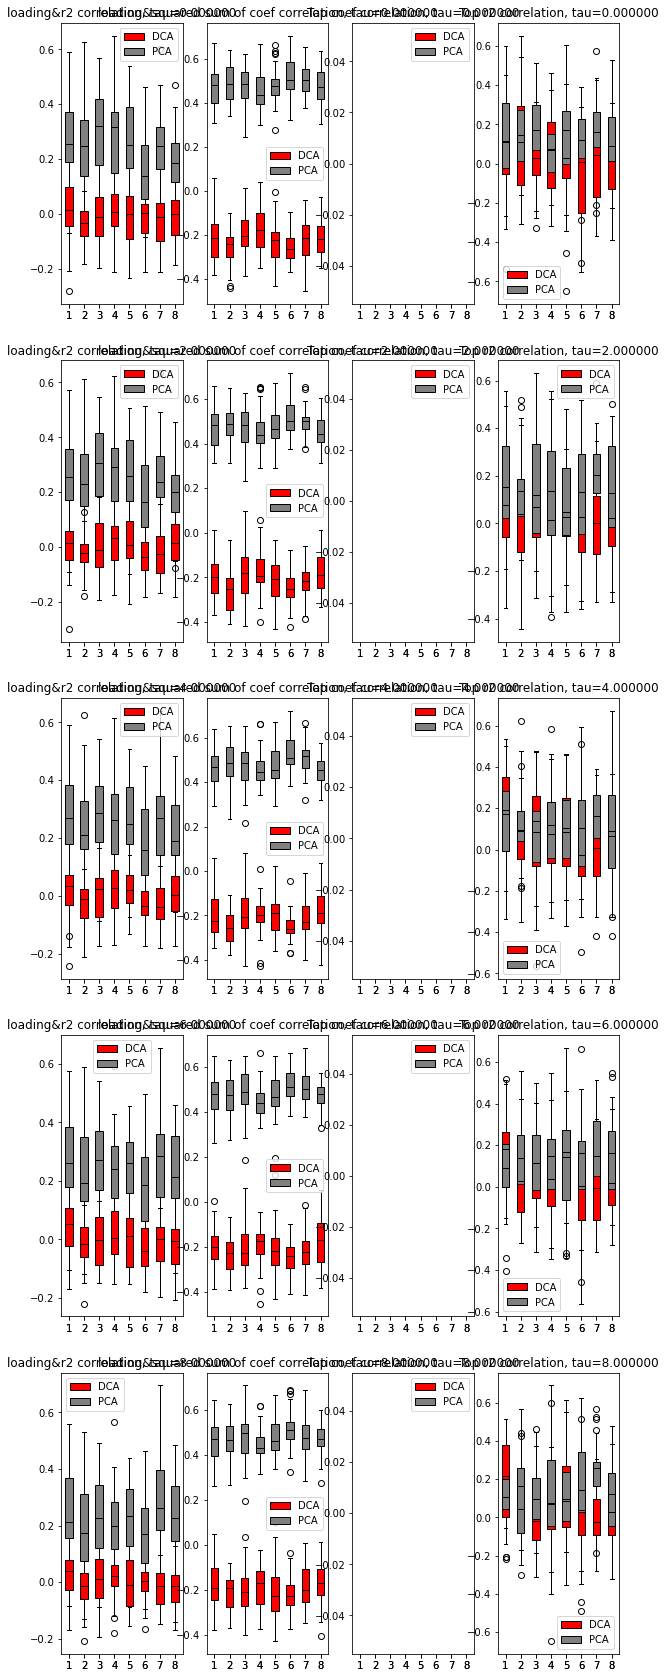

In [29]:
import matplotlib.pyplot as plt

def box_plot(ax, data, edge_color, fill_color):
    bp = ax.boxplot([data[i, :] for i in range(data.shape[0])], patch_artist=True)
    
    for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color=edge_color)

    for patch in bp['boxes']:
        patch.set(facecolor=fill_color)       
        
    return bp
    
tau = [0, 2, 4, 6, 8]

shape = ((8, len(tau), 28))
    
cor_bins_coef_dca = np.zeros(shape)
cor_bins_r2_dca = np.zeros(shape)
cor_bins_coef_pca = np.zeros(shape)
cor_bins_r2_pca = np.zeros(shape)

cor_bins_dca_tc = np.zeros(shape)
cor_bins_dca_tr2 = np.zeros(shape)
cor_bins_pca_tc = np.zeros(shape)
cor_bins_pca_tr2 = np.zeros(shape)

for bin_idx in range(8):
    for tidx, t_ in enumerate(tau):
        df_ = result_df.loc[result_df['bin_idx'] == bin_idx].loc[result_df['tau'] == t_]
        
        cor_bins_coef_dca[bin_idx, tidx] = df_['spr_coef_dca'].values
        cor_bins_r2_dca[bin_idx, tidx] = df_['spr_r2_dca'].values
        cor_bins_coef_pca[bin_idx, tidx] = df_['spr_coef_pca'].values
        cor_bins_r2_pca[bin_idx, tidx] = df_['spr_r2_pca'].values
        
        cor_bins_dca_tc[bin_idx, tidx] = df_['spr_coef_dca_tc'].values
        cor_bins_dca_tr2[bin_idx, tidx] = df_['spr_r2_dca_tr2'].values

        cor_bins_pca_tc[bin_idx, tidx] = df_['spr_coef_pca_tc'].values
        cor_bins_pca_tr2[bin_idx, tidx] = df_['spr_r2_pca_tr2'].values

fig, ax = plt.subplots(5, 4, figsize=(10, 30))

for i in range(len(tau)):

    a = ax[i, 0]    
    a.title.set_text("loading&r2 correlation, tau=%f" % tau[i])
    bp1 = box_plot(a, cor_bins_r2_dca[:, i, :], 'black', 'red')
    bp2 = box_plot(a, cor_bins_r2_pca[:, i, :], 'black', 'grey')
    a.legend([bp1["boxes"][0], bp2["boxes"][0]], ['DCA', 'PCA'])
    
    a = ax[i, 1]    
    a.title.set_text("loading&squared sum of coef correlation, tau=%f" % tau[i])
    bp1 = box_plot(a, cor_bins_coef_dca[:, i, :], 'black', 'red')
    bp2 = box_plot(a, cor_bins_coef_pca[:, i, :], 'black', 'grey')
    a.legend([bp1["boxes"][0], bp2["boxes"][0]], ['DCA', 'PCA'])

    a = ax[i, 2]    
    a.title.set_text("Top coef correlation, tau=%f" % tau[i])
    bp1 = box_plot(a, cor_bins_dca_tc[:, i, :], 'black', 'red')
    bp2 = box_plot(a, cor_bins_pca_tc[:, i, :], 'black', 'grey')
    a.legend([bp1["boxes"][0], bp2["boxes"][0]], ['DCA', 'PCA'])

    a = ax[i, 3]    
    a.title.set_text("Top r2 correlation, tau=%f" % tau[i])
    bp1 = box_plot(a, cor_bins_dca_tr2[:, i, :], 'black', 'red')
    bp2 = box_plot(a, cor_bins_pca_tr2[:, i, :], 'black', 'grey')
    a.legend([bp1["boxes"][0], bp2["boxes"][0]], ['DCA', 'PCA'])

    

In [64]:
# This is good enough